Final version of the code of ODE simulation without lags. 

In [5]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *
from ODE_utils import *

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

Find a rho^star that makes equal first-niche growth-rates for both diauxers and co-utilizers
- generated from gaussian: $c_ik_i$
- coefficient for metabolic enzyme reallocation: $\left(\frac{\rho \cdot n+(1-\rho) \cdot n_R}{n}\right)$
- real growth rate: $g_\rho=\left(\frac{1}{\sum_i^{n_R} \tilde{g}_{\rho i} E_{\rho i}^{\max }}+\frac{1}{g_C}\right)^{-1}$.

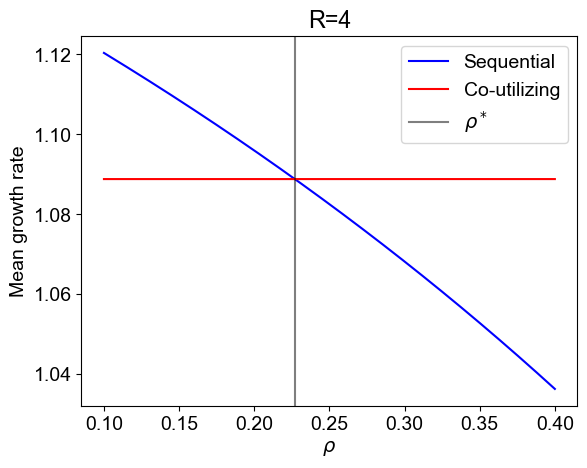

The rho^*:
[0.20415207603801902, 0.21585792896448225, 0.22696348174087044, 0.23356678339169587, 0.23956978489244624, 0.24362181090545273, 0.2505252626313157, 0.255927963981991, 0.25682841420710356, 0.2629814907453727, 0.2661330665332666, 0.26883441720860435, 0.2712356178089045, 0.27393696848424215, 0.27543771885942975, 0.2778389194597299, 0.2799399699849925, 0.2815907953976989, 0.28354177088544275]


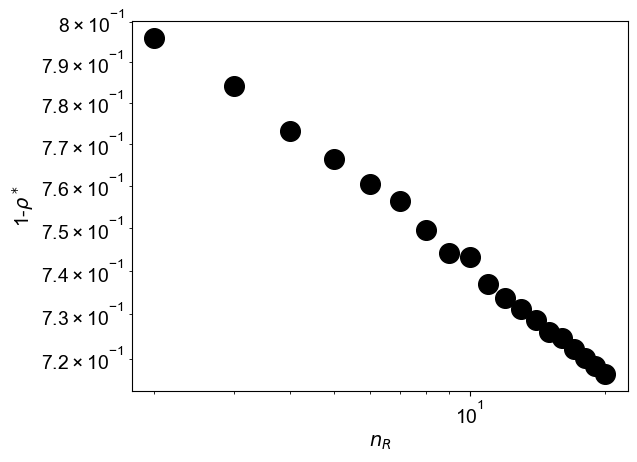

In [112]:
gC = 1.5
Nsamples = 10000
rhos = np.linspace(0.1, 0.4, 2000)
R_example = 4

Rlist = np.arange(2, 21)
rho_list = []

for R in Rlist:
    g_diauxs = []
    g_couts = []
    for i in range(Nsamples):
        g1 = generate_g(1, R)
        g2 = generate_g(1, R)
        gt_1 = (rhos+(1-rhos)*R)*np.max(g1)
        gt_2 = np.sum(g2)+rhos-rhos
        g_diauxs.append(1/(1/gt_1+1/gC))
        g_couts.append(1/(1/gt_2+1/gC))
    g_diauxs = np.mean(np.vstack(g_diauxs), axis=0)
    g_couts = np.mean(np.vstack(g_couts), axis=0)
    if(R==R_example):
        plt.plot(rhos, g_diauxs, c="b", label="Sequential")
        plt.plot(rhos, g_couts, c="r", label="Co-utilizing")
        plt.xlabel("$\\rho$")
        plt.ylabel("Mean growth rate")
        plt.title(f"R={R}")
        rho_s = rhos[np.abs(g_diauxs-g_couts).argmin()]
        plt.axvline(rho_s, label="$\\rho^*$", color="k", alpha=0.5)
        plt.legend()
        plt.show()
    rho_list.append(rhos[np.abs(g_diauxs-g_couts).argmin()])

plt.scatter(Rlist, 1-np.array(rho_list), s=200, c="k")
# plt.plot(Rlist, 1-np.array(rho_list))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$n_R$")
plt.ylabel("1-$\\rho^*$")

print("The rho^*:")
print(rho_list)

In [2]:
class SeqUt_alt: # sequential utilizer
    def __init__(self, rho, g_enz, gC, pref_list, biomass, id):
        '''
        growth_Rate_list_single: float array[N_res], generated from gaussian
        pref_list: int array[N_res]
        biomass: float
        '''
        self.cat = "Seq"
        self.id = id
        self.gC = gC
        self.rho = rho
        self.alive = True
        self.nr = len(g_enz)
        self.g = g_enz # g here is already converted from gaussian and by Terry's physiology
        self.pref = pref_list
        self.b = biomass
        self.eating = np.array([False for i in range(self.nr)]) # default - not eating anything
        self.inlag = False
    def Dilute(self, D):
        '''
        D: float
        '''
        self.b /= D
        if(self.b<DIEOUT_BOUND):
            self.alive = False
    def GetEating(self, Rs):
        '''
        Rs: float array of all resources
        '''
        self.eating = np.array([False for i in range(self.nr)])
        for r in self.pref:
            if(Rs[r-1]>0):
                self.eating[r-1] = True
                break
    def GetGrowthRate(self):
        n = len(self.g)
        gtilde = self.g * (self.rho + (1-self.rho)*n)
        return (gtilde/(1+gtilde/self.gC)) @ self.eating
    def GetDep(self):
        '''
        In all cases assume yield Y=1
        '''
        return self.eating.astype(float)
    

class CoUt_alt: # coutilizer
    def __init__(self, rho, g_enz, gC, biomass, id):
        '''
        growth_Rate_list_single: float array[1, N_res]
        gC: float
        biomass: float
        '''
        self.cat = "Cout"
        self.id = id
        self.rho = rho
        self.alive = True
        self.nr = len(g_enz)
        self.g = g_enz # g here is already converted from gaussian and by Terry's physiology
        self.gC = gC
        self.b = biomass
        self.eating = np.array([False for i in range(self.nr)]) # default - not eating anything
        self.inlag = False
    def Dilute(self, D):
        '''
        D: float, dilution factor
        '''
        self.b /= D
        if(self.b<DIEOUT_BOUND):
            self.alive = False
    def GetEating(self, Rs):
        '''
        Rs: float array of all resources
        '''
        self.eating = (Rs>0)
    def GetGrowthRate(self): # growth rate of the sepcies with non-zero resources in R_left
        g_vec = self.g[self.eating]
        n = len(self.g)
        n_eat = np.sum(self.eating)
        if(True not in self.eating):
            return 0
        else:
            return ( ( np.sum(g_vec) * (self.rho*n_eat + (1-self.rho)*n)/n_eat )**-1 + 1/self.gC )**-1
    def GetDep(self):
        '''
        In all cases assume yield Y=1
        Get the fraction of each resource in the biomass gained by this co-utilizer
        '''
        dep = np.zeros(self.nr)
        dep[self.eating] = self.g[self.eating]/np.sum(self.g[self.eating])
        return dep

In [79]:
# generate species pool for simulations on the cluster
Nseq, Ncout = 500, 500
Ntrials = 200
D = 100
T_dilute = 24
gC = 1.5
STEADY_CRIT = 1e-6
MAX_CYCLE = 1e5
R = 4
rhos = np.linspace(0, 0.8, 101)
path = "../../ODE-related/seq_vs_co_0213"

# generate the species pool and corresponding environment
for rho in tqdm(rhos):
    experiments = {"D": D, "gC": gC, "R": R, "Nseq":Nseq, "Ncout":Ncout, "initials":[]}
    for i in range(Ntrials):
        # generate the pool
        # seq -- top smart
        g_seq = generate_g(Nseq, R)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=Nseq))
        col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref_list):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        # cout
        g_cout = generate_g(Ncout, R)
        # make list of species
        species_list = []
        for i in range(Nseq):
            species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=i))
        for i in np.arange(Nseq, Nseq+Ncout):
            species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=i))
        
        # make the random supply of species -- uniformly sample on symplex
        cuts = np.sort(np.random.rand(R-1))
        cuts = np.insert(cuts, 0, 0)
        cuts = np.insert(cuts, R, 1)
        Rs = (cuts[1:]-cuts[:-1])*R

        experiments["initials"].append([species_list, Rs])
    savefile = os.path.join(path, f"intial_a={rho}.pkl")
    pickle.dump(experiments, open(savefile, "wb"))

100%|██████████| 101/101 [04:23<00:00,  2.60s/it]


In [4]:
# load the data and make the plot
R = 4
rhos = np.linspace(0, 0.8, 101)
path = "../../ODE-related/seq_vs_co_0213"
# get the result for pairwise
frac_diaux_pair = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"pairwise_rho={rho}.pkl"), "rb"))
    basic = data["basic"]
    D, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
    states = data["end"]["states"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux_pair.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
# # get the results for community
frac_diaux = []
div = []
stratified = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"full_rho={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    div.append(np.mean([len(i) for i in ids]))
    frac_diaux_strat = []
    lenlist = []
    for num in range(R):
        ids_list = sum([i for i in ids if len(i)==num+1], [])
        if(len(ids_list)>0):
            frac_diaux_strat.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
        else:
            frac_diaux_strat.append(0)
        lenlist.append(len(ids_list))
    stratified.append([lenlist, frac_diaux_strat])

100%|██████████| 101/101 [02:05<00:00,  1.24s/it]


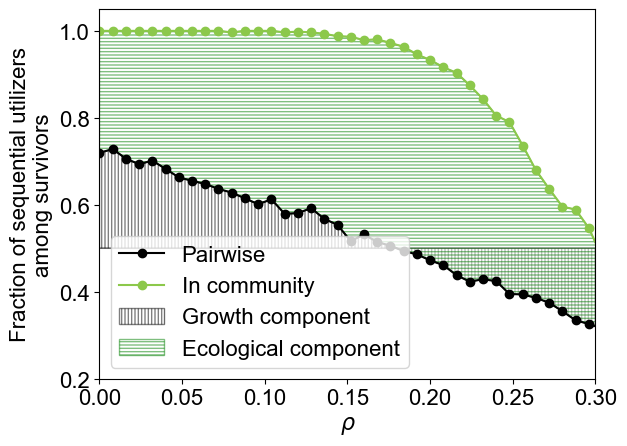

In [6]:
plt.plot(rhos, frac_diaux_pair, color='k', marker="o", label="Pairwise")
plt.plot(rhos, frac_diaux, color='#8CC84B', marker="o", label="In community")
# plt.axvline(0.22, color='r', rho=0.4, label="$\\rho^*$")
plt.axhline(0.5, color="k", alpha=0.2)
plt.fill_between(rhos, 0.5, frac_diaux_pair, color='w', hatch="|"*5, edgecolor='k', alpha=0.5, label="Growth component")
plt.fill_between(rhos, frac_diaux, frac_diaux_pair, color='w', hatch="-"*5, edgecolor='g', alpha=0.5, label = "Ecological component")
plt.xlabel("$\\rho$")
plt.ylabel("Fraction of sequential utilizers\namong survivors")
plt.xlim(0, 0.3)
plt.ylim(0.2, 1.05)
plt.legend()
plt.savefig("figs/pairwise_vs_community.pdf")

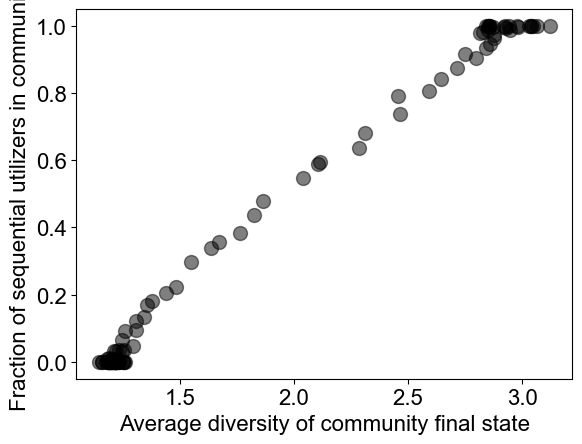

In [7]:
plt.scatter(div, frac_diaux, color='k', alpha=0.5, s=100)
plt.ylabel("Fraction of sequential utilizers in community")
plt.xlabel("Average diversity of community final state")
plt.savefig("figs/diversity.pdf")

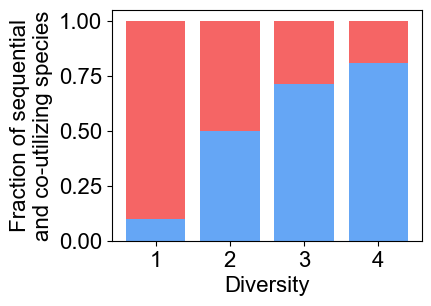

In [13]:
for i in range(60):
    if(0<(frac_diaux[i]-0.5)<0.05):
        plt.figure(figsize=(4, 3))
        plt.bar(np.arange(1, 5), [1, 1, 1, 1], color="#F56565")
        plt.bar(np.arange(1, 5), stratified[i][1], color = "#65A6F5")
        plt.xticks(np.arange(1, 5))
        # plt.axhline(frac_diaux[i], color='k')
        plt.xlabel("Diversity")
        plt.ylabel("Fraction of sequential\nand co-utilizing species")
        plt.savefig("figs/example.pdf",bbox_inches = 'tight')
        plt.show()

In [49]:
### for supplementary figure:
# 1. saturation of species pool size
# load the data and make the plot
R = 4
path = "../../ODE-related/seq_vs_co_0120"
path_alt = "../../ODE-related/seq_vs_co_0120_alt"
rhos = np.linspace(0, 0.3, 60)
# get the result for pairwise
frac_diaux_pair = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"pairwise_alpha={rho}.pkl"), "rb"))
    basic = data["basic"]
    D, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
    states = data["end"]["states"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux_pair.append(len([i for i in ids_list if i<Nseq])/len(ids_list)-0.05)
# get the results for community of 500
frac_diaux = []
div = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"full_alpha={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    div.append(np.mean([len(i) for i in ids]))
# get the results for community of 200
N_use = 200
frac_diaux_200 = []
div_200 = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path_alt, f"N_use={N_use}_alpha={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    N_seq = N_use
    ids_list = sum(ids, [])
    frac_diaux_200.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    div_200.append(np.mean([len(i) for i in ids]))

N_use = 100
frac_diaux_100 = []
div_100 = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path_alt, f"N_use={N_use}_alpha={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    N_seq = N_use
    ids_list = sum(ids, [])
    frac_diaux_100.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    div_100.append(np.mean([len(i) for i in ids]))

N_use = 50
frac_diaux_50 = []
div_50 = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path_alt, f"N_use={N_use}_alpha={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    N_seq = N_use
    ids_list = sum(ids, [])
    frac_diaux_50.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    div_50.append(np.mean([len(i) for i in ids]))

N_use = 10
frac_diaux_10 = []
div_10 = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path_alt, f"N_use={N_use}_alpha={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    N_seq = N_use
    ids_list = sum(ids, [])
    frac_diaux_10.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    div_10.append(np.mean([len(i) for i in ids]))

N_use = 5
frac_diaux_5 = []
div_5 = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path_alt, f"N_use={N_use}_alpha={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    N_seq = N_use
    ids_list = sum(ids, [])
    frac_diaux_5.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    div_5.append(np.mean([len(i) for i in ids]))

100%|██████████| 60/60 [00:02<00:00, 21.22it/s]


0 [0.14490609]
1 [0.23829778]
2 [0.2448688]
3 [0.27134624]
4 [0.27786324]
5 [0.28637759]
6 [0.29664249]


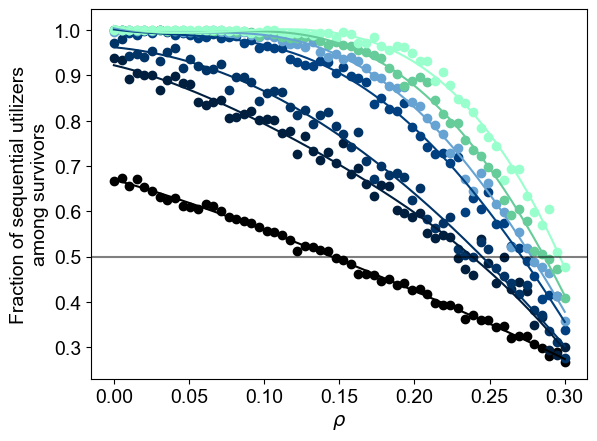

In [84]:
from scipy.optimize import fsolve
Nlist = [2, 10, 20, 100, 200, 400, 1000]
y_list = [frac_diaux_pair, frac_diaux_5, frac_diaux_10, frac_diaux_50, frac_diaux_100, frac_diaux_200, frac_diaux]
color_list = ["k", "#001F3F", "#003366", "#004080", "#66A3D2", "#66CC99", "#99FFCC"]
root_list = []
for i in range(len(y_list)):
    coefficients = np.polyfit(rhos, y_list[i], 4)
    x_values = np.linspace(0, 0.3, 500)
    plt.plot(x_values, np.poly1d(coefficients)(x_values), color=color_list[i])
    plt.scatter(rhos, y_list[i], color=color_list[i], marker="o")
    root_list.append(fsolve(lambda x: np.poly1d(coefficients)(x) - 0.5, x0=0.3))
    print(i, root_list[-1])
plt.axhline(0.5, color="k", alpha=0.5)
plt.xlabel("$\\rho$")
plt.ylabel("Fraction of sequential utilizers\namong survivors")
plt.savefig("figs/community_effect.pdf")

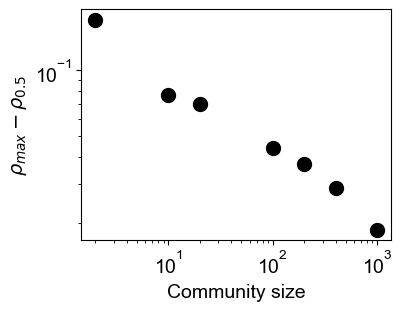

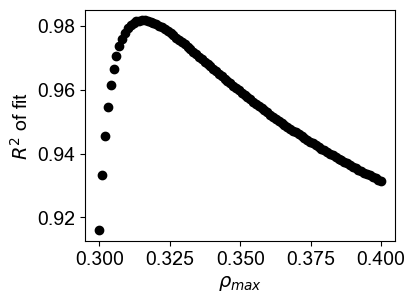

In [109]:
from scipy.stats import linregress
guess_max = np.linspace(0.3, 0.4, 100)
rs = []
for i in guess_max:
    xs = [log(j) for j in Nlist]
    ys = [log(i-j[0]) for j in root_list]
    slope, intercept, r_value, p_value, std_err = linregress(xs, ys)
    rs.append(r_value**2)

best_guess = guess_max[rs.index(max(rs))]
xs = Nlist
ys = [best_guess-j[0] for j in root_list]
plt.figure(figsize=(4, 3))
plt.scatter(xs, ys, s=100, c='k')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Community size")
plt.ylabel("$\\rho_{max}-\\rho_{0.5}$")
plt.show()

plt.figure(figsize=(4, 3))
plt.scatter(guess_max, rs, c='k')
plt.xlabel("$\\rho_{max}$")
plt.ylabel("$R^2$ of fit")
plt.show()


15